## Настройки и импорты

In [ ]:
# Базовые библиотеки и модули
import os                       # Работа с операционной системой
import numpy as np              # Работа с массивами
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt # Визуализация графиков
import warnings                 # Управление предупреждениями
from tqdm.notebook import tqdm  # Прогресс-бар для ноутбуков
import glob                     # Работа с путями файлов
import cv2                      # Работа с видео

# Keras
import tensorflow as tf       # Импорт TensorFlow
from tensorflow import keras  # Импорт Keras


# Функции для загрузки и преобразования изображений
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model   # Модели
from tensorflow.keras import layers                     # Слои для моделей
from tensorflow.keras.optimizers import Adam            # Оптимизатор Adam
from tensorflow.keras.losses import BinaryCrossentropy  # Функция потерь Binary Cross Entropy
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input


# Отключение вывода предупреждений
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Подключение Google Drive
from google.colab import drive
drive.mount('/content/drive/')

# Вывод списка доступных устройств
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


## Загрузка данных

Датасет взять с https://www.kaggle.com/datasets/soumikrakshit/anime-faces

In [2]:
!cp /content/drive/MyDrive/Презентации/archive.zip /content/arhive.zip

In [ ]:
!unzip /content/arhive.zip

In [2]:
# Установка базового каталога с изображениями
BASE_DIR = '/content/data/'

In [3]:
# Получение всех путей к изображениям с расширением .png в каталоге
image_paths = glob.glob(BASE_DIR+'*.png')
print(image_paths[:3]) # Вывод первых трех путей к изображениям
print("Count images:", len(image_paths)) # Вывод количества изображений

['/content/data/16284.png', '/content/data/14307.png', '/content/data/19463.png']
Count images: 21551


In [5]:
# Функция для отображения изображений в сетке
def display_images_grid(image_paths, grid_size=7):
    plt.figure(figsize=(5, 5))
    temp_images = image_paths[:grid_size * grid_size] # Ограничение количества изображений
    for index, image_path in enumerate(temp_images, start=1):
        plt.subplot(grid_size, grid_size, index) # Создание подграфика
        img = np.array(load_img(image_path)) # Загрузка изображения
        plt.imshow(img) # Отображение изображения
        plt.axis('off') # Отключение осей

In [ ]:
display_images_grid(image_paths) # Вызов функции для отображения изображений

## Предобработка данных

In [19]:
# Функция для чтения и предварительной обработки изображений
def read_and_preprocess_images(image_paths):
    train_images = [np.array(load_img(path)) for path in tqdm(image_paths)] # Загрузка изображений
    train_images = np.array(train_images) # Преобразование в массив numpy
    train_images = train_images.astype('float32') # Изменение типа данных изображений
    train_images = (train_images - 127.5) / 127.5 # Нормализация изображений в диапазон [-1, 1]
    return train_images

In [ ]:
# Загрузка и обработка изображений
train_images = read_and_preprocess_images(image_paths)
print(train_images.shape) # Вывод размерности массива с изображениями

## Описание архитектуры

In [21]:
# Размерность для случайного шума
LATENT_DIM = 100
# Инициализатор весов
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Количество каналов изображения (3 для RGB, 1 для оттенков серого)
CHANNELS = 3

### Генератор

Генератор использует слои обратной свёртки для создания изображений из случайного шума.

In [ ]:
# Создание модели генератора
model = Sequential(name='generator')

# 1d случайный шум
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
model.add(layers.ReLU())

# Преобразование из 1d в 3d
model.add(layers.Reshape((8, 8, 512)))

# Увеличение размера до 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# Увеличение размера до 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# Увеличение размера до 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# Заключительный сверточный слой
model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

# Модель генератора
generator = model
generator.summary()

### Дискриминатор
Дискриминатор – это сверточная нейронная сеть, которая классифицирует изображения как настоящие или сгенерированные.

In [ ]:
# Создание модели дискриминатора
model = Sequential(name='discriminator')
input_shape = (64, 64, 3) # Размер входного изображения
alpha = 0.2 # Параметр утечки для функции активации LeakyReLU

# Создание сверточных слоев
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape)) # Сверточный слой с 64 фильтрами
model.add(layers.BatchNormalization()) # Нормализация по батчу
model.add(layers.LeakyReLU(alpha=alpha)) # Функция активации LeakyReLU

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape)) # Сверточный слой с 128 фильтрами
model.add(layers.BatchNormalization()) # Нормализация по батчу
model.add(layers.LeakyReLU(alpha=alpha)) # Функция активации LeakyReLU

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape)) # Сверточный слой с 128 фильтрами
model.add(layers.BatchNormalization()) # Нормализация по батчу
model.add(layers.LeakyReLU(alpha=alpha)) # Функция активации LeakyReLU

# Выравнивание и регуляризация
model.add(layers.Flatten()) # Выравнивание данных в одномерный вектор
model.add(layers.Dropout(0.3)) # Слой регуляризации для предотвращения переобучения

# Выходной слой для классификации
model.add(layers.Dense(1, activation='sigmoid')) # Выходной слой с сигмоидной активацией для бинарной классификации

# Модель дискриминатора
discriminator = model
discriminator.summary() # Вывод структуры модели

### DCGAN

В GAN тренировка дискриминатора и генератора происходит в отдельных шагах. Дискриминатор обучается на реальных и сгенерированных изображениях, в то время как генератор обучается, пытаясь обмануть дискриминатор.

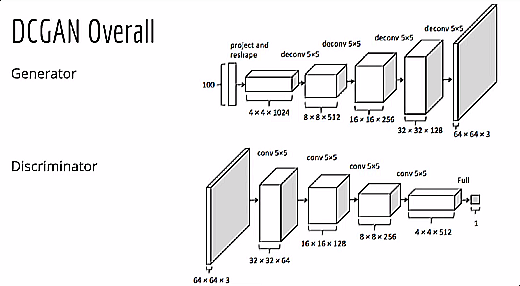

In [24]:
class DCGAN(keras.Model):
    # Инициализация модели
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator # Генератор
        self.discriminator = discriminator # Дискриминатор
        self.latent_dim = latent_dim # Размерность латентного пространства
        # Метрики потерь для обеих моделей
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    # Метод для получения метрик
    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    # Компиляция модели
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer # Оптимизатор для генератора
        self.d_optimizer = d_optimizer # Оптимизатор для дискриминатора
        self.loss_fn = loss_fn # Функция потерь

    # Обучение модели
    def train_step(self, real_images):
        # Получение размера батча из данных
        batch_size = tf.shape(real_images)[0]
        # Генерация случайного шума
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Обучение дискриминатора на реальных (1) и сгенерированных (0) изображениях
        with tf.GradientTape() as tape:
            # Вычисление потерь на реальных изображениях
            pred_real = self.discriminator(real_images, training=True)
            # Генерация меток для реальных изображений
            real_labels = tf.ones((batch_size, 1))
            # Сглаживание меток
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Вычисление потерь на сгенерированных изображениях
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # Генерация меток для сгенерированных изображений
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # Общий уровень потерь дискриминатора
            d_loss = (d_loss_real + d_loss_fake) / 2

        # Вычисление градиентов для дискриминатора
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Обновление градиентов
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))


        # Обучение модели генератора
        labels = tf.ones((batch_size, 1))
        # Генератор хочет, чтобы дискриминатор считал сгенерированные изображения реальными
        with tf.GradientTape() as tape:
            # Генерация сгенерированных изображений
            fake_images = self.generator(random_noise, training=True)
            # Классификация изображений как реальных или сгенерированных
            pred_fake = self.discriminator(fake_images, training=True)
            # Вычисление уровня потерь
            g_loss = self.loss_fn(labels, pred_fake)

        # Вычисление градиентов для генератора
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # Обновление градиентов
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # Обновление состояния для обеих моделей
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}


In [25]:
path_to_save_imgs = "/content/gen_process" # Путь по сохранению изображений
os.makedirs(path_to_save_imgs, exist_ok=True) # Проверка существования директории и ее создание

In [26]:
# Функция предварительной обработки изображений в режиме обучения
def preprocess(images, while_train = False):
    if while_train == True:
        images = (images - 127.5) / 127.5 # Нормализация изобzражений
        images.numpy() # Преобразование изображений в numpy массив
    else:
        images = images.astype('float32') # Преобразование типа данных изображений
        images = (images - 127.5) / 127.5 # Нормализация изображений
    return images

In [27]:
# Класс callback для отслеживания процесса обучения DCGAN
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs # Количество изображений для генерации
        self.latent_dim = latent_dim # Размерность латентного пространства
        # Создание случайного шума для генерации изображений
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # Генерация изображения из шума
        g_img = self.model.generator(self.noise)
        # Денормализация изображения
        g_img = preprocess(g_img, while_train = True)

        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = array_to_img(g_img[i])
            plt.imshow(img)
            plt.axis('off')
        plt.savefig(path_to_save_imgs + '/epoch_{:03d}.png'.format(epoch))
        plt.show()
        self.model.generator.save('generator.h5') # Сохранение модели генератора
        self.model.discriminator.save('discriminator.h5') # Сохранение модели дискриминатора

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5') # Сохранение модели генератора после окончания обучения
        self.model.discriminator.save('discriminator.h5') # Сохранение модели дискриминатора после окончания обучения

In [28]:
# Создание экземпляра DCGAN, передав генератор, дискриминатор и размерность  пространства шума
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [29]:
# Определение скоростей обучения для генератора и дискриминатора
D_LR = 0.0001
G_LR = 0.0003

# Компиляция модели с оптимизатором Adam и функцией потерь Binary Cross-Entropy
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

In [ ]:
# Количество эпох для обучения
N_EPOCHS = 100

# Обучение модели на тренировачных изображениях
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

## Тестирование

Значение FID (Fréchet Inception Distance)— это численная метрика, которая используется для оценки качества сгенерированных изображений по сравнению с реальными. Эта метрика оценивает различия в распределениях признаков между реальными и сгенерированными изображениями, вычисленными с использованием модели Inception.

FID является обратной мерой схожести, так что более низкие значения указывают на более высокую схожесть между сгенерированными и реальными изображениями, в то время как более высокие значения указывают на большее различие.

In [36]:
def calculate_fid(model, images1, images2):
    # Рассчитывает FID (Frechet Inception Distance) между двумя массивами изображений
    # Получение активаций модели для двух массивов изображений
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # Вычисление средних и ковариационных матриц для активаций
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Вычисление суммы квадратов разностей между средними значениями
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Вычисление произведения квадратных корней из ковариационных матриц
    covmean = sqrtm(sigma1.dot(sigma2))

    # Если результат является комплексным числом, использовать только действительную часть
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Рассчитывание FID, используя вычисленные статистики
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

In [37]:
def test_gan(generator_path, z_dim, train_images, num_samples=1000):
    # Загрузка модели генератора
    generator = load_model(generator_path)

    # Генерация шума и создание сгенерированных изображений
    noise = tf.random.normal([num_samples, z_dim])
    generated_images = generator(noise)
    generated_images = (generated_images + 1) / 2.0  # Денормализация изображений

    # Вывод сгенерированных изображений, например, первых 5
    for i in range(5):
        plt.figure(figsize=(5, 5))
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.show()

    # Загрузка модели InceptionV3 для вычисления FID
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))

    # Изменение размера настоящих и сгенерированных изображений до (75, 75)
    real_images_resized = tf.image.resize(train_images[:num_samples], (75, 75))
    generated_images_resized = tf.image.resize(generated_images, (75, 75))

    # Предварительная обработка изображений для модели InceptionV3
    real_images_resized = preprocess_input(real_images_resized)
    generated_images_resized = preprocess_input(generated_images_resized)

    # Рассчет FID между настоящими и сгенерированными изображениями
    fid_value = calculate_fid(model, real_images_resized, generated_images_resized)
    print(f"FID: {fid_value} на {num_samples} изображений")

In [ ]:
# Путь к сохраненной модели генератора
generator_path = '/content/generator.h5'

# Размер входного шума для генератора
z_dim = 100
img_shape = train_images.shape[1:]
test_gan(generator_path, z_dim, train_images, num_samples=100)

# Бонус

In [ ]:
def images_to_video(image_folder, video_path="video.mp4", fps=30):
    # Сортировка изображений в папке по номеру эпохи
    filenames = sorted(os.listdir(image_folder), key=lambda x: int(x.split("_")[1].split(".")[0]))

    # Чтение первого изображения для определения размеров видео
    first_image = cv2.imread(os.path.join(image_folder, filenames[0]))
    height, width, layers = first_image.shape

    # Создание объекта VideoWriter для записи видео с указанными размерами и частотой кадров
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Кодек для видео
    video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

    # Проход по всем изображениям в папке и добавление их в видео
    for filename in tqdm(filenames):  # tqdm используется для отображения прогресса
        if filename.endswith(".png"):  # Обрабатываются только файлы с расширением .png
            filepath = os.path.join(image_folder, filename)
            image = cv2.imread(filepath)
            video.write(image)

    # Закрытие объекта VideoWriter и освобождение ресурсов
    cv2.destroyAllWindows()
    video.release()

# Пример использования функции для создания видео из изображений, сохраненных в path_to_save_imgs
images_to_video(path_to_save_imgs)
